[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1fozmAoAAm2NcpOx66wUNnXqBQycYXlnX#scrollTo=KICTR2HtEcU9)

# About this notebook

In this notebook, we apply CIDRE to the original example code in order to replicate the original experiments and aid in validating the results.

**The purpose of this notebook is to simply demonstrate that the original CIDRE code is fully functional and has been replicated by a third party (myself, Gregory Pollard).**

# CITATION:

The code in this notebook and at its associated Github connection was entirely copied from the original CIDRE Github found [here](https://github.com/skojaku/cidre).


**Paper:** Detecting anomalous citation groups in journal networks

**Authors:** Kojaku, Sadamori and Livan, Giacomo and Masuda, Naoki

**Journal:** Sci. Rep.

**Publisher:** Nature Publishing Group

## Preparation

### Install CIDRE package

First, we install `cidre` package with `pip`:

In [ ]:
!pip install cidre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.1 MB 41.9 MB/s 
     |████████████████████████████████| 285 kB 37.2 MB/s 
     |████████████████████████████████| 13.1 MB 27.0 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.


### Loading libraries

Next, we load some libraries:

In [ ]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

Finding communities requires the graph-tool package. This can be installed easily on Unix machines with:



```
conda install -c conda-forge graph-tool
```

Or, in Google Colab, we may use:

In [ ]:
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib


# Journals of 2020 Example

We apply CIDRE as in the original experiments but on the Microsoft Academic Graph Data set for the **new, unseen** journals of 2020.

In [ ]:
# Data path
edge_file = "https://raw.githubusercontent.com/gpollard647/CIDRE_Diss/main/Validation_Code/data/journal-citation/edge-table-2020.csv"

# Load edges
A, node_labels = cidre.utils.read_edge_list(edge_file)

## About this network

This network is a citation network of journals in 2020 constructed from Microsoft Academic Graph.
Each edge is weighted by the number of citations made to the papers in the prior two years.
The following are basic statistics of this network.

In [ ]:
print("Number of nodes: %d" % A.shape[0])
print("Number of edges: %d" % A.sum())
print("Average degree: %.2f" % (A.sum()/A.shape[0]))
print("Max in-degree: %d" % np.max(A.sum(axis = 0)))
print("Max out-degree: %d" % np.max(A.sum(axis = 1)))
print("Maximum edge weight: %d" % A.max())
print("Minimum edge weight: %d" % np.min(A.data))

Number of nodes: 29083
Number of edges: 8238276
Average degree: 283.27
Max in-degree: 197438
Max out-degree: 97620
Maximum edge weight: 14120
Minimum edge weight: 1


## Detecting anomalous groups in the network

 Firstly, we must detect the natural, healthy communities that form in journal networks and remove them. To do this, we use the non-parametric Bayesian degree-correct Stochastic Block Model. [In the original CIDRE paper](https://www.nature.com/articles/s41598-021-93572-3), the authors defined `detect_community()` that utilises the [graph-tool](https://graph-tool.skewed.de/) package to do this.

In [ ]:
import graph_tool.all as gt

def detect_community(A, K = None, **params):
    """Detect communities using the graph-tool package

    :param A: adjacency matrix
    :type A: scipy.csr_sparse_matrix
    :param K: Maximum number of communities. If K = None, the number of communities is automatically determined by graph-tool.
    :type K: int or None
    :param params: parameters passed to graph_tool.gt.minimize_blockmodel_dl
    """
    def to_graph_tool_format(adj, membership=None):
        g = gt.Graph(directed=True)
        r, c, v = sparse.find(adj)
        nedges = v.size
        edge_weights = g.new_edge_property("double")
        g.edge_properties["weight"] = edge_weights
        g.add_edge_list(
            np.hstack([np.transpose((r, c)), np.reshape(v, (nedges, 1))]),
            eprops=[edge_weights],
        )
        return g
    G = to_graph_tool_format(A)

    states = gt.minimize_blockmodel_dl(
        G,
        state_args=dict(eweight=G.ep.weight),
        multilevel_mcmc_args = {"B_max": A.shape[0] if K is None else K },
        **params
    )
    b = states.get_blocks()
    return np.unique(np.array(b.a), return_inverse = True)[1]

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo._cairo'
  warnings.warn(msg, RuntimeWarning)


Next, we can detect the community in our sparse adjacency matrix A.

In [ ]:
group_membership = detect_community(A)

Finally, we deplot CIDRE and pass in these communities (`group_membership`), the statisitcal significance for the null model (`alpha`), and the minimum weight an edge must have in order to be considered (`min_edge_weight`). With this CIDRE class instance `alg` use its attribute `detect()` with A and the value of theta (`threshold`) that corresponds with the JCR's requirements for sufficient within-group citations (15%).

In [ ]:
alg = cidre.Cidre(group_membership = group_membership,alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 1327
Number of groups detected: 55


The largest group is, in fact, an outlier for this year's data. If we omit it, we obtain new limits.

In [ ]:
group_sizes = np.array([group.size() for group in groups])
max_index = np.argmax(group_sizes)
groups = list(filter(lambda group: group != groups[max_index], groups))
group_sizes.sort()
group_sizes = group_sizes[:-1]
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 25
Number of groups detected: 54


[In the orignal CIDRE paper](https://www.nature.com/articles/s41598-021-93572-3), the authors omitted the groups that have within-group citations less than 50 because we expect that anomalous citation groups contain sufficiently many within-group citations.

In [ ]:
groups_detected = [group for group in groups if group.get_num_edges()>=50]
len_groups = len(groups_detected)

where `group.get.num_edges()` gives the sum of the weights of the non-self-loop edges within the group.

## Visualization

Let us visualize the groups detected by CIDRE for the new, unseen 2020 MAG dataset. For expository purposes, we sample three groups to visualize uniformly at random. We omit detected groups with a size greater than 100 as it incredibly unlikely that this many journals are meaningfully colluding to game the JIF, we mark these as  

In [ ]:
groups_for_vis = [group for group in groups if group.get_num_edges()>=50 and group.size() < 100]
groups_sampled = [groups_for_vis[i] for i in np.random.choice(len(groups_for_vis), 3, replace = False)]

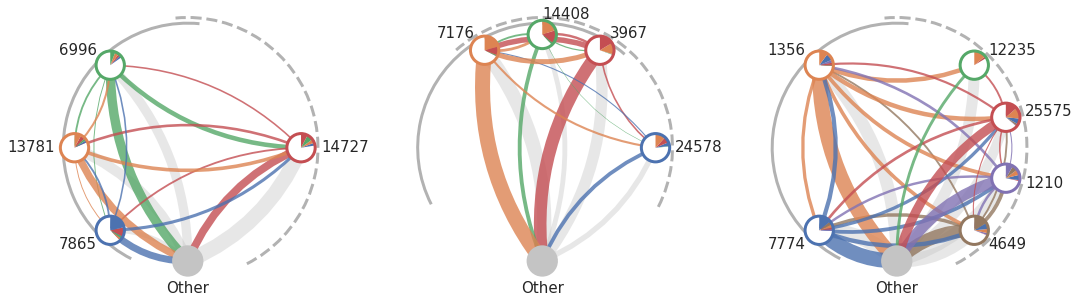

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(6 * 3, 5))

for i in range(3):
    cidre.DrawGroup().draw(groups_sampled[i], ax = axes.flat[i])

The numbers beside the nodes are the IDs of the journals in the network. To show the journals' names, we do the following. 


First, we load node labels and make a dictionary that maps the ID of each node to the label:

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/gpollard647/CIDRE_Diss/main/Validation_Code/data/journal-citation/journals_of_interest.csv")
journalid2label = dict(zip(df.journal_id.values, df.name.values)) # Dictionary from MAG journal ID to the journal name
id2label = {k:journalid2label[v] for k, v in node_labels.items()} # This is a dictionary from ID to label, i.e., {ID:journal_name}

Then, give `id2label` to `cidre.DrawGroup.draw`, i.e.,  

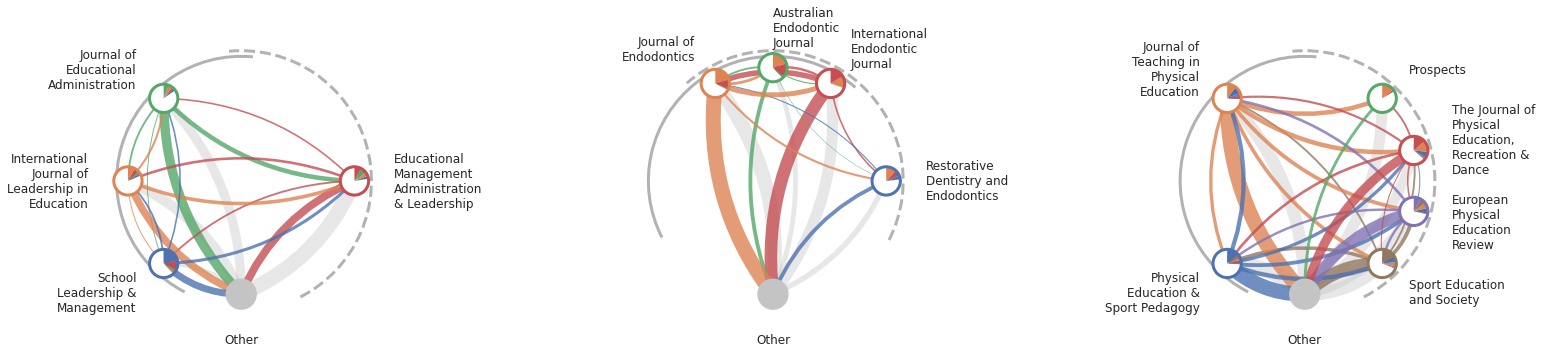

In [ ]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(9 * 3, 5))

for i in range(3):
    plotter = cidre.DrawGroup()
    plotter.font_size = 12 # Font size
    plotter.label_node_margin = 0.7 # Margin between labels and node
    plotter.draw(groups_sampled[i], node_labels = id2label, ax = axes.flat[i])

As a further visualisation, let's see the distribution of group size with a boxplot.

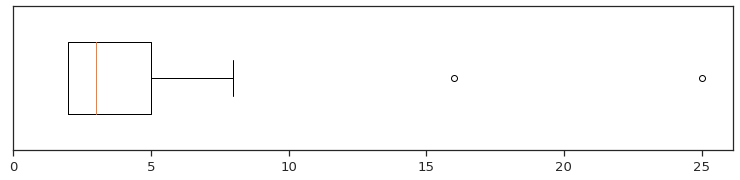

In [ ]:
fig = plt.figure(figsize =(10, 2))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(group_sizes,vert=False,widths=0.5)
plt.yticks([])
print()
plt.xticks(np.arange(0,30,5))
plt.show()

## Evaluation

Let's evaluate how well CIDRE did on the 2020 data set by finding the precision and recall with the JCR suppressions for 2020 in-place of the real 'ground truth'. First, we import the journal names of JCR suppressions for 2020 that were due to citation-stacking. 

Then, for each group detected by CIDRE, we'd like to test how many journals in the group were suspended from 2020 JCR out of all the journals (precision).

Finally, we are also interested in how many of the journals in each group are we suspended from 2020 JCR out of all JCR suspensions (recall).

In [184]:
JCR_2020_suppressions = pd.read_csv("https://raw.githubusercontent.com/gpollard647/CIDRE_Diss/main/Validation_Code/data/journal-citation/JCR_2020_suppressions.csv")


precision = dict()
recall = dict()
groupID = 0
for group in groups_for_vis:
  journal_names_in_group = list()

  for node in group.node_ids:
    journal_names_in_group.append(id2label[node])
  
  # Precision:
  TP = [journal for journal in journal_names_in_group if journal.lower() in map(str.lower, JCR_2020_suppressions["journal_name"].tolist())]
  TP = len(TP)
  P = group.size()
  precision[groupID] = TP/P

  #Recall
  T = len(JCR_2020_suppressions)
  recall[groupID] = TP/T

  groupID += 1

  
  
print("Precision is: " + str(precision.values()))
print("Recall is: "+str(recall.values()))

Precision is: dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Recall is: dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
